In [1]:
# Delete and make these folders before starting - debug, artifacts

import json
import pickle
import time
import datetime
import logging
import cv2

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torchvision as tv
from torch.optim import Adam

import get_data_loaders, get_Image_Transform_Network, get_VGG_network, utils


#To compare across results
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4

# Can re_size to the size you want 
utils.resize_to_fixed("sketch.jpg", "sketch_256.jpg")
TRAIN_STYLE_IMAGE = "sketch_256.jpg"

# Or use the image as it is, the model will do a centre crop of TRAIN_IMAGE_SIZE later
# TRAIN_STYLE_IMAGE = "starry_night.jpeg"

# Can adjust scaling factor later to tune further
scale_factor = [1.]
LEARNING_RATE = 0.001*scale_factor[0]

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}


#Loading pickled dataloader
try:
    with open('dataloader_pickled.pickle', 'rb') as f:
        test_train_loader = pickle.load(f)
except:
    #Using COCO dataset. Use the first time, and then pickle it 
    train_loader = get_data_loaders.get_classic_dataset(image_size=TRAIN_IMAGE_SIZE, batch_size= BATCH_SIZE)
    #Pickling
    test_train_loader = get_data_loaders.get_classic_dataset()
    with open("dataloader_pickled.pickle","wb") as f:
        pickle.dump(test_train_loader,f, protocol=pickle.HIGHEST_PROTOCOL)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    vgg_network = get_VGG_network.VGGNetwork()
    vgg_network.eval()
    vgg_network.to(device)

style_img_tensor = utils.get_batch_tensor_from_image(image=TRAIN_STYLE_IMAGE, image_size=TRAIN_IMAGE_SIZE, device=device) #[1,3, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE]

# The network to be trained. Three variants are available - padded one, and non-padded one
# test_net = get_Image_Transform_Network.RTST_ImgTfNet_NoPadding()
# test_net = get_Image_Transform_Network.RTST_ImgTfNetPadding()
test_net  = get_Image_Transform_Network.RTST_ImgTfNet_InstanceNorm()

test_net.train()
optimizer = Adam(test_net.parameters(), LEARNING_RATE)

test_vgg_network = vgg_network
mse_loss = nn.MSELoss()

with torch.no_grad():
    style_loss_features = test_vgg_network(style_img_tensor)
    gram_style = [utils.gram_matrix(y) for y in style_loss_features]
    
    
#Experimental Weights
TV_REG_WEIGHT = 1e-6  #order of 1e-5: 1e-6 don't want the pixel loss to impact the stylization too much
STYLE_LOSS_WEIGHTS = [1e3, 1e5, 1e5, 1e5] #change and experiment for different layers
CONTENT_LOSS_WEIGHT = 1.

In [2]:
def train(starts_at=0,steps=100, PRINT_FREQUENCY=10,SAVE_FREQUENCY = 200, cost_curves_filename = "./artifacts/loss_details_per_epoch.txt"):
    test_net.train()
    count = starts_at
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    
    while True:
        for x, _ in test_train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = test_net(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = test_vgg_network(y)
            features_xc = test_vgg_network(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_LOSS_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = TV_REG_WEIGHT * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_LOSS_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = utils.gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            
            
            if count % PRINT_FREQUENCY == 0:
                
                loss_dict = {"epoch":count,
                         "agg_content_loss": agg_content_loss.item()/PRINT_FREQUENCY,
                         "agg_style_loss": agg_style_loss.item()/PRINT_FREQUENCY,
                         "agg_reg_loss": agg_reg_loss.item()/PRINT_FREQUENCY,
                         "total_loss": (agg_content_loss.item() +agg_style_loss.item() +agg_reg_loss.item() )/ PRINT_FREQUENCY}
            
                
                now = datetime.datetime.now()
                time_stamp = now.strftime("%H:%M:%S")
                message = f"{time_stamp} {count}/{steps} Content Loss: {agg_content_loss / PRINT_FREQUENCY:.2f}  Style Loss: {agg_style_loss / PRINT_FREQUENCY :.2f}  Reg Loss: {agg_reg_loss / PRINT_FREQUENCY :.2f} Total Loss: {(agg_content_loss + agg_style_loss + agg_reg_loss ) / PRINT_FREQUENCY:.6f}"
                
                #Write losses to a txt file for plotting cost curves later
                with open(cost_curves_filename,"a") as f:             
                    f.write(str(loss_dict)+"\n")
          
                print(message)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                
            #Save model every SAVE_FREQUENCY batches
            if count%SAVE_FREQUENCY==0:
                
                #change to eval mode before saving a few intermediate results
                test_net.eval()
                y = test_net(x)           
                torch.save(test_net.state_dict(), f"./artifacts/saved_model_{count}")
                current_time = now.strftime("%H:%M:%S")
                utils.save_debug_image(x, y.detach(), f"./debug/{count}_{current_time}.png")

                test_net.train()

            if count>=steps:
                return
            

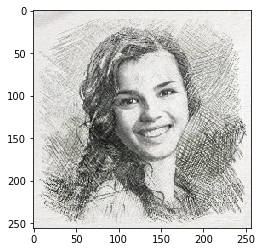

In [3]:
plt.show()
plt.imshow(utils.get_numpy_image_to_plot(style_img_tensor.cpu().detach().numpy())[0])

In [4]:
train(0,40000)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


21:28:44 10/40000 Content Loss: 5.24  Style Loss: 56.39  Reg Loss: 0.21 Total Loss: 61.834560
21:28:46 20/40000 Content Loss: 9.30  Style Loss: 29.63  Reg Loss: 0.60 Total Loss: 39.520443
21:28:47 30/40000 Content Loss: 11.76  Style Loss: 12.70  Reg Loss: 0.91 Total Loss: 25.370928
21:28:49 40/40000 Content Loss: 12.41  Style Loss: 9.60  Reg Loss: 0.94 Total Loss: 22.949278
21:28:50 50/40000 Content Loss: 12.23  Style Loss: 8.65  Reg Loss: 0.93 Total Loss: 21.808187
21:28:51 60/40000 Content Loss: 12.14  Style Loss: 7.39  Reg Loss: 0.99 Total Loss: 20.519026
21:28:53 70/40000 Content Loss: 12.13  Style Loss: 6.91  Reg Loss: 0.98 Total Loss: 20.021078
21:28:54 80/40000 Content Loss: 12.13  Style Loss: 6.27  Reg Loss: 0.99 Total Loss: 19.387537
21:28:56 90/40000 Content Loss: 12.27  Style Loss: 5.93  Reg Loss: 0.98 Total Loss: 19.186426
21:28:57 100/40000 Content Loss: 12.12  Style Loss: 5.68  Reg Loss: 0.98 Total Loss: 18.774654
21:28:58 110/40000 Content Loss: 11.98  Style Loss: 5.38  

In [ ]:
# train(30100,30200)

In [ ]:
# Model saving,reloading

#torch.save(test_net.state_dict(), "saved_model")

# test_net  = get_Image_Transform_Network.RTST_ImgTfNet_InstanceNorm()
# test_net.load_state_dict(torch.load("./artifacts/saved_model_29000"))

In [ ]:
#for Testing
for x, _ in test_train_loader:
    test_new_content = x.to(device)
    break

img_output = test_net(test_new_content)
plt.imshow(utils.get_numpy_image_to_plot(test_new_content.cpu().detach().numpy())[0])

In [ ]:
plt.imshow(utils.get_numpy_image_to_plot(img_output.cpu().detach().numpy())[0])